In [ ]:
%matplotlib inline


# Compute source space connectivity and visualize it using a circular graph


This example computes the all-to-all connectivity between 68 regions in
source space based on dSPM inverse solutions and a FreeSurfer cortical
parcellation. The connectivity is visualized using a circular graph which
is ordered based on the locations of the regions.



Automatically created module for IPython interactive environment
Using default location ~/mne_data for sample...
Creating ~/mne_data

[........................................] 100.00000 - (1.35 GB / 1.35 GB)    
Verifying download hash.
Decompressing the archive: C:\Users\Dominik\mne_data\MNE-sample-data-processed.tar.gz
(please be patient, this can take some time)
Attempting to create new mne-python configuration file:
C:\Users\Dominik\AppData\Roaming\.mne\mne-python.json
Reading inverse operator decomposition from C:\Users\Dominik\mne_data\MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 2249

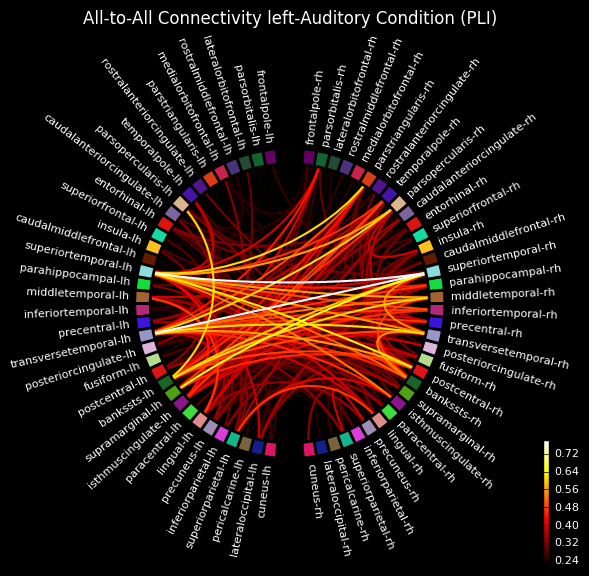

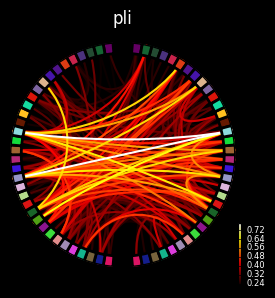

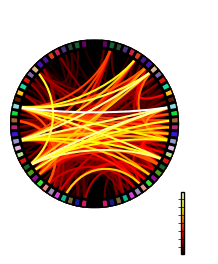

In [1]:
# Authors: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
#          Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#          Nicolas P. Rougier (graph code borrowed from his matplotlib gallery)
#
# License: BSD (3-clause)

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle

print(__doc__)

data_path = sample.data_path()
subjects_dir = data_path + '/subjects'
fname_inv = data_path + '/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif'
fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'

# Load data
inverse_operator = read_inverse_operator(fname_inv)
raw = mne.io.read_raw_fif(fname_raw)
events = mne.read_events(fname_event)

# Add a bad channel
raw.info['bads'] += ['MEG 2443']

# Pick MEG channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=True,
                       exclude='bads')

# Define epochs for left-auditory condition
event_id, tmin, tmax = 1, -0.2, 0.5
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=dict(mag=4e-12, grad=4000e-13,
                                                    eog=150e-6))

# Compute inverse solution and for each epoch. By using "return_generator=True"
# stcs will be a generator object instead of a list.
snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot('sample', parc='aparc',
                                    subjects_dir=subjects_dir)
label_colors = [label.color for label in labels]

# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator['src']
label_ts = mne.extract_label_time_course(stcs, labels, src, mode='mean_flip',
                                         return_generator=True)

# Now we are ready to compute the connectivity in the alpha band. Notice
# from the status messages, how mne-python: 1) reads an epoch from the raw
# file, 2) applies SSP and baseline correction, 3) computes the inverse to
# obtain a source estimate, 4) averages the source estimate to obtain a
# time series for each label, 5) includes the label time series in the
# connectivity computation, and then moves to the next epoch. This
# behaviour is because we are using generators and allows us to
# compute connectivity in computationally efficient manner where the amount
# of memory (RAM) needed is independent from the number of epochs.
fmin = 8.
fmax = 13.
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['pli', 'wpli2_debiased']
con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
    fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

# con is a 3D array, get the connectivity for the first (and only) freq. band
# for each method
con_res = dict()
for method, c in zip(con_methods, con):
    con_res[method] = c[:, :, 0]

# Now, we visualize the connectivity using a circular graph layout

# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
plot_connectivity_circle(con_res['pli'], label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors,
                         title='All-to-All Connectivity left-Auditory '
                               'Condition (PLI)')
plt.savefig('circle.png', facecolor='black')

# Plot connectivity for both methods in the same plot
fig = plt.figure(num=None, figsize=(8, 4), facecolor='black')
no_names = [''] * len(label_names)
for ii, method in enumerate(con_methods):
    plot_connectivity_circle(con_res[method], no_names, n_lines=300,
                             node_angles=node_angles, node_colors=label_colors,
                             title=method, padding=0, fontsize_colorbar=6,
                             fig=fig, subplot=(1, 2, ii + 1))

plt.show()